In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import *
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
import os
plt.style.use("fivethirtyeight")

In [81]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [83]:
filenames=tf.io.gfile.glob(str(GCS_PATH+"/chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH+"/chest_xray/val/*/*")))
train,val=train_test_split(filenames,test_size=0.2)


In [5]:
len(train)

4185

In [84]:
Norm=len([i for i in train if "NORMAL" in i])
Psue=len([j for j in train if "PNEUMONIA" in j])
print(f"Normal {Norm}")
print(f"Pneumonia {Psue}")


Normal 1069
Pneumonia 3116


In [85]:
Train=tf.data.Dataset.from_tensor_slices(train)
Val=tf.data.Dataset.from_tensor_slices(val)
Train

<TensorSliceDataset shapes: (), types: tf.string>

In [86]:
def get_label(path):
    parts=tf.strings.split(path,os.path.sep)
    print(parts)
    return parts[-2]=="PNEUMONIA"

def decode(img):
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    return tf.image.resize(img,[180,180])
def process_inp(path):
    label=get_label(path)
    img=tf.io.read_file(path)
    img=decode(img)
    return img,label


In [87]:
Train=Train.map(process_inp,num_parallel_calls=AUTOTUNE)
Val=Val.map(process_inp,num_parallel_calls=AUTOTUNE)


Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


In [88]:
for i,j in Train.take(1):
    print(j)
    

tf.Tensor(False, shape=(), dtype=bool)


In [89]:
test=tf.data.Dataset.list_files(str(GCS_PATH+"/chest_xray/test/*/*"))
test=test.map(process_inp,num_parallel_calls=AUTOTUNE)


Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


In [90]:
tf.data.experimental.cardinality(test).numpy()

624

In [91]:
Train=Train.batch(64,drop_remainder=True)
Val=Val.batch(64)
Train=Train.prefetch(AUTOTUNE)
Val=Val.prefetch(AUTOTUNE)


In [92]:
Train

<PrefetchDataset shapes: ((64, 180, 180, 3), (64,)), types: (tf.float32, tf.bool)>

In [93]:
I,L=next(iter(Train))


In [94]:
I=I.numpy()
L=L.numpy()


ValueError: num must be 1 <= num <= 15, not 16

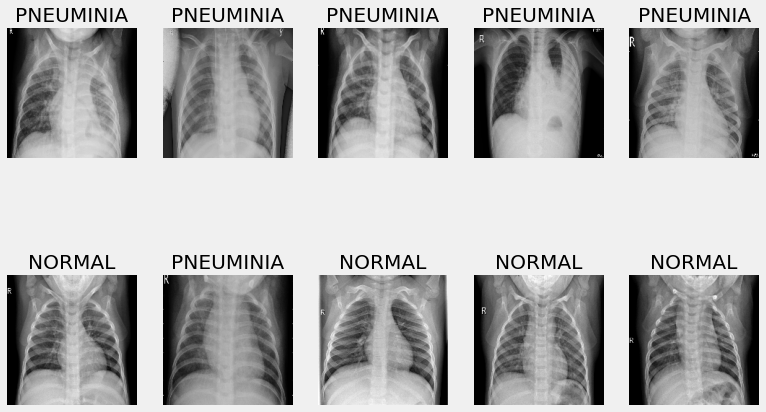

In [109]:
 plt.figure(figsize=(12,12))
for i in range(5,20):
   
    ax=plt.subplot(3,5,i-5+1)
    plt.imshow(I[i],cmap=plt.cm.jet)
    if L[i]==False:
        plt.title("NORMAL")
    else:
        plt.title("PNEUMINIA")
    plt.axis("off")
    plt.savefig("box23.png")
    

In [99]:
normal_weight=(1/Norm)*((4185)/2.0)
pseu_weight=(1/Psue)*((4185)/2.0)


In [100]:
W={0:normal_weight,1:pseu_weight}


In [101]:
W

{0: 1.9574368568755847, 1: 0.6715340179717586}

In [102]:
def conv_block():
    I=Input((180,180,3))
    C1=Conv2D(16,3,activation="relu",padding="same")(I)
    M1=MaxPooling2D()(C1)
    C2=Conv2D(16,3,activation="relu",padding="same")(M1)
    M2=MaxPooling2D()(C2)
    C3=SeparableConv2D(32,3,activation="relu",padding="same")(M2)
    C4=SeparableConv2D(32,3,activation="relu",padding="same")(C3)
    B1=BatchNormalization()(C4)
    M3=MaxPooling2D(pool_size=(2,2))(B1)
    C5=SeparableConv2D(64,3,activation="relu",padding="same")(M3)
    C6=SeparableConv2D(64,3,activation="relu",padding="same")(C5)
    B2=BatchNormalization()(C6)
    M4=MaxPooling2D(pool_size=(2,2))(B2)
    D1=Dropout(0.3)(M4)
    C7=SeparableConv2D(128,3,activation="relu",padding="same")(D1)
    C8=SeparableConv2D(128,3,activation="relu",padding="same")(C7)
    B3=BatchNormalization()(C8)
    M5=MaxPooling2D(pool_size=(2,2))(B3)
    D2=Dropout(0.4)(M5)
    F=Flatten()(D2)
    Dn1=Dense(512,activation="relu")(F)
    Dn2=Dense(128,activation="relu")(Dn1)
    D3=Dropout(0.4)(Dn2)
    Dn3=Dense(64,activation="relu")(D3)
    Dnf=Dense(1,activation="sigmoid")(Dn3)
    model=tf.keras.models.Model(I,Dnf)
    return model

            
    
    
    
    
    

In [103]:
with strategy.scope():
    model=conv_block()
    model.summary()
    Metrics=[
    "accuracy",
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
    ]
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=Metrics)
    


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
separable_conv2d_25 (Separab (None, 45, 45, 64)        2400      
_________________________________________________________________
separable_conv2d_26 (Separab (None, 45, 45, 64)        4736

In [73]:
clear

In [104]:
Train_count=4185
Val_count=1097


In [105]:
history=model.fit(Train,epochs=15,validation_data=Val,class_weight=W)
model.save("PN.h5")





Epoch 1/15
65/65 [==============================] - 154s 2s/step - recall_2: 0.7635 - loss: 0.3579 - precision_2: 0.9637 - accuracy: 0.8026 - val_recall_2: 1.0000 - val_loss: 0.5809 - val_precision_2: 0.7326 - val_accuracy: 0.7326
Epoch 2/15
65/65 [==============================] - 110s 2s/step - recall_2: 0.9338 - loss: 0.1544 - precision_2: 0.9857 - accuracy: 0.9406 - val_recall_2: 1.0000 - val_loss: 0.5846 - val_precision_2: 0.7326 - val_accuracy: 0.7326
Epoch 3/15
65/65 [==============================] - 105s 2s/step - recall_2: 0.9409 - loss: 0.1180 - precision_2: 0.9881 - accuracy: 0.9476 - val_recall_2: 1.0000 - val_loss: 0.5902 - val_precision_2: 0.7326 - val_accuracy: 0.7326
Epoch 4/15
65/65 [==============================] - 110s 2s/step - recall_2: 0.9561 - loss: 0.1027 - precision_2: 0.9900 - accuracy: 0.9601 - val_recall_2: 1.0000 - val_loss: 0.6741 - val_precision_2: 0.7326 - val_accuracy: 0.7326
Epoch 5/15
65/65 [==============================] - 108s 2s/step - recall_2: